<a href="https://colab.research.google.com/github/iamRahulB/Pytorch-practice/blob/main/Pytorch_transfer_learning_CNN_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from zipfile import ZipFile
import os

In [3]:
data_path="data"



In [4]:
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
model=torchvision.models.efficientnet_b0(weights=weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 30.1MB/s]


In [7]:
auto_transform=weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

we will use same image transfor as used by efficient net while pretraining

In [8]:
# transform_train=transforms.Compose([
#     transforms.Resize(size=(224,224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225]),
#     # transforms.RandomHorizontalFlip(p=0.5),
#     # transforms.ColorJitter(brightness=0.02)
# ])

# transform_test=transforms.Compose([
#     transforms.Resize(size=(224,224)),
#     transforms.ToTensor(),

# ])

In [9]:
# we wil not use ImageFolder as we can directly download image

train_data=datasets.CIFAR10(root=data_path,
                            train=True,
                            transform=auto_transform,
                            target_transform=None,
                            download=True,
                        )

test_data=datasets.CIFAR10(root=data_path,
                           train=False,
                           transform=auto_transform,
                           target_transform=None,
                           download=True)

100%|██████████| 170498071/170498071 [00:06<00:00, 26527842.81it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


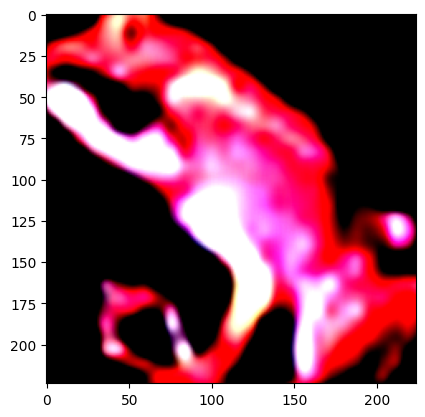

In [10]:
plt.imshow(train_data[103][0].permute(1,2,0))

In [11]:
train_data.classes, train_data.class_to_idx

(['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 {'airplane': 0,
  'automobile': 1,
  'bird': 2,
  'cat': 3,
  'deer': 4,
  'dog': 5,
  'frog': 6,
  'horse': 7,
  'ship': 8,
  'truck': 9})

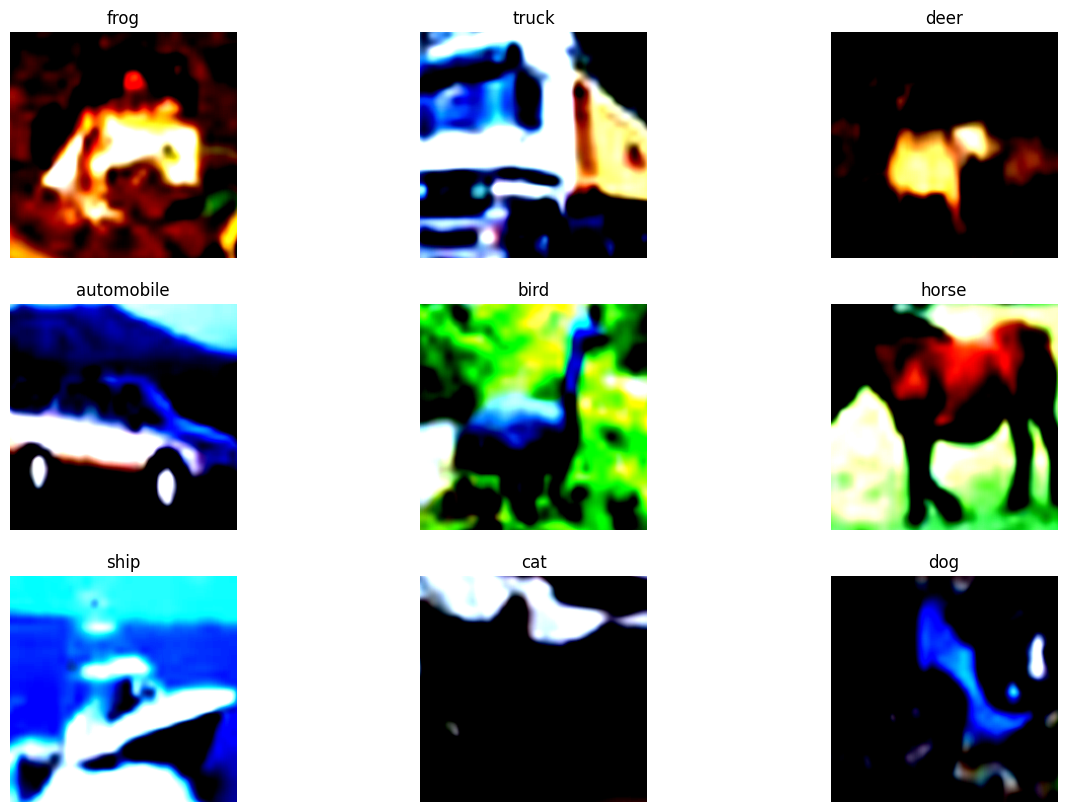

In [12]:
found = []
unique_targets = list(train_data.class_to_idx.values())
class_names = train_data.classes

plt.figure(figsize=(15, 10))

for i, (image, label) in enumerate(train_data):
    if label not in found:
        found.append(label)
        plt.subplot(3, 3, len(found))
        plt.imshow(image.permute(1, 2, 0))
        plt.title(class_names[label])
        plt.axis('off')
    if len(found) == 9:
        break



In [13]:
train_loader=DataLoader(dataset=train_data,batch_size=32,shuffle=True,)

test_loader=DataLoader(dataset=test_data,batch_size=32,shuffle=False,)

Note: In previous versions of torchvision, you'd create a pretrained model with code like:

model = torchvision.models.efficientnet_b0(pretrained=True).to(device)

However, running this using torchvision v0.13+ will result in errors such as the following:

UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.

In [14]:
# model=torchvision.models.efficientnet_b0(pretrained=True)    # its optinal and further dont need to load weights but they say dont use this method
# so we download weights and then load

In [15]:
# weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
# weights

In [16]:
# default_transforms=weights.transforms()
# default_transforms      # this is image transforms used while training model, we need to use this same

In [17]:
# now we have weights we will load weights

# model=torchvision.models.efficientnet_b0(weights=weights)

now we will freeze the features of the model, features means the layers in which model learns or extracts the feature, conv2d is the feature layer, maxpool is not feature but it downsamples image, and change classifier layer according too our classes


below layer we will change and freeze all previous
    
    Linear-255                 [-1, 1000]

In [18]:
# We can freeze all of the layers/parameters in the features section by setting the attribute requires_grad=False.

# requires_grad=False  means weights will not be tracked so they will not get updated so we can use default weights

for param in model.features.parameters():
    param.requires_grad=False


**Feature extractor layers frozen!**

In [19]:
output_class=len(train_data.classes)
output_class

10

In [20]:
#  to know name of the layer we need to change print model architechture and go at last and see.

#  in this classifier is the name of last stack

layer=model.classifier
layer


Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [21]:
print(f"layer 1 in classifeir stack: {layer[1]}\n")

print(f"in features of this model: {layer[1].in_features}")

layer 1 in classifeir stack: Linear(in_features=1280, out_features=1000, bias=True)

in features of this model: 1280


In [22]:
model.classifier[1]=nn.Linear(in_features=1280,out_features=output_class)

In [23]:
# all done now lets see last layer is changed or not


model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [24]:

!pip install -q torchinfo

In [25]:
# we frozen the features using below code

# for param in model.features.parameters():
#     param.requires_grad=False

# before doing this we could see True in model summary as they were trainable now we will check after freezing its true or false
#  false means we will not update any params from those layers

from torchinfo import summary

summary(model,(1,3,224,224),col_names=["input_size", "output_size", "num_params", "trainable"])    # NCHW --> BATCH CHANNEL HIGHT WIDTH

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [1, 3, 224, 224]          [1, 10]                   --                        Partial
├─Sequential: 1-1                                       [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        False
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─Sequential

In [26]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [27]:
from tqdm.auto import tqdm

In [28]:
device=("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
model=model.to(device)

In [30]:
from sklearn.metrics import accuracy_score

In [31]:
torch.manual_seed(42)

epochs=5

for epoch in tqdm(range(epochs)):
    train_loss = 0
    train_acc = 0
    model.train()
    for batch, (X_train, y_train) in enumerate(train_loader):
        X_train=X_train.to(device)
        y_train=y_train.to(device)

        X_train, y_train = X_train.to(device), y_train.to(device)
        y_logits = model(X_train)
        train_batch_preds = y_logits.argmax(dim=1)
        train_batch_loss = loss_fn(y_logits, y_train)
        train_batch_acc = accuracy_score(y_train.cpu(), train_batch_preds.cpu())

        train_loss += train_batch_loss.item()
        train_acc += train_batch_acc
        optimizer.zero_grad()
        train_batch_loss.backward()
        optimizer.step()

        # if batch % 10 == 0:
        #     print(f"Train Loss: {train_batch_loss.item()} | Train ACC: {train_batch_acc}")

    model.eval()
    train_acc /= len(train_loader)
    train_loss /= len(train_loader)
    test_loss = 0
    test_acc = 0
    with torch.inference_mode():
        for X_test, y_test in test_loader:
            X_test=X_test.to(device)
            y_test=y_test.to(device)
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_test_logits = model(X_test)
            test_batch_preds = y_test_logits.argmax(dim=1)
            test_batch_loss = loss_fn(y_test_logits, y_test)
            test_batch_acc = accuracy_score(y_test.cpu(), test_batch_preds.cpu())

            test_loss += test_batch_loss.item()
            test_acc += test_batch_acc

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train ACC: {train_acc*100:.2f} | Test Loss: {test_loss:.4f} | Test ACC: {test_acc*100:.2f}")



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.8759 | Train ACC: 71.76 | Test Loss: 0.6064 | Test ACC: 79.67
Epoch: 1 | Train Loss: 0.7125 | Train ACC: 75.87 | Test Loss: 0.5775 | Test ACC: 80.30
Epoch: 2 | Train Loss: 0.6933 | Train ACC: 76.15 | Test Loss: 0.5701 | Test ACC: 80.32
Epoch: 3 | Train Loss: 0.6792 | Train ACC: 76.77 | Test Loss: 0.5503 | Test ACC: 81.15
Epoch: 4 | Train Loss: 0.6806 | Train ACC: 76.74 | Test Loss: 0.5507 | Test ACC: 80.85


In [33]:
#  previously on testing data i was not applying same transformations but using only for train data, so
# its cruicial to use same transformation to training and testing set while training, --> resize , any mean, std,

# nromalize we should use for both but image change transformation should be applied to train only as we are not learning from test data

#  below code is correct but mean std should be applied for test also, or we should definately use the transforms used by main model that is efficient net ..

# transform_train=transforms.Compose([
#     transforms.Resize(size=(224,224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225]),
#     # transforms.RandomHorizontalFlip(p=0.5),
#     # transforms.ColorJitter(brightness=0.02)
# ])

# transform_test=transforms.Compose([
#     transforms.Resize(size=(224,224)),
#     transforms.ToTensor(),

# ])

In [34]:
train_data.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [59]:
# making predictions on images downloaded from google

links={
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQvsamw0Db3_uGffNnTJ_ZvUjrMeItOH2lhIw&s",
    "https://images.pexels.com/photos/210019/pexels-photo-210019.jpeg?cs=srgb&dl=pexels-pixabay-210019.jpg&fm=jpg",
    "https://cdn.pixabay.com/photo/2016/12/13/22/25/bird-1905255_640.jpg",
    "https://hips.hearstapps.com/hmg-prod/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg?crop=0.752xw:1.00xh;0.175xw,0&resize=1200:*",
    'https://media.istockphoto.com/id/472109275/photo/beautiful-landscape-in-norther-part-of-india.jpg?s=612x612&w=0&k=20&c=buwJ4p_z4Ty3SPgMCNUpmncxWZUtXSvUgREyCQeORtU='
}

In [60]:
custom="custom_images"
import os

os.makedirs(custom,exist_ok=True)
for ind,val in enumerate(links):
    response=requests.get(val)
    with open(f"{custom}/image_{ind}.jpg",'wb') as f:
        f.write(response.content)

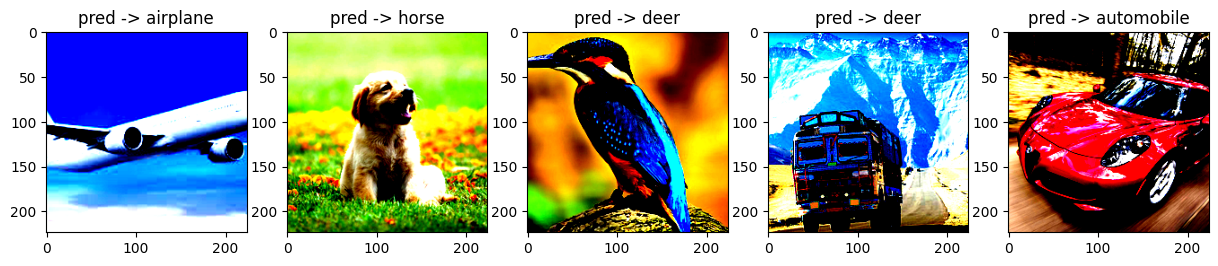

In [69]:
from PIL import Image
count=1

plt.figure(figsize=(15,7))
for files in os.listdir(custom):
    img=Image.open(os.path.join(custom,files))

    img_tensor=auto_transform(img)    # conver it into tensor



    # print(f"shape of image after conversion-- {img_tensor.unsqueeze(dim=0).shape}")
    with torch.inference_mode():
        checks=model(img_tensor.unsqueeze(dim=0).to(device))
        # print(f"Model Predicted---> {train_data.classes[torch.argmax(checks,dim=1).item()]}")

    plt.subplot(1,5,count)
    plt.imshow(img_tensor.permute(1,2,0))
    count+=1
    plt.title(f"pred -> {train_data.classes[torch.argmax(checks,dim=1).item()]}")



